[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 274, number of used features: 5
[LightGBM] [Info] Start training from score 34456.347656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

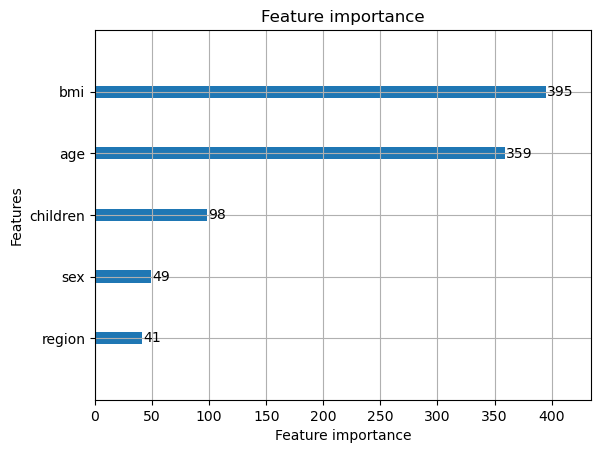

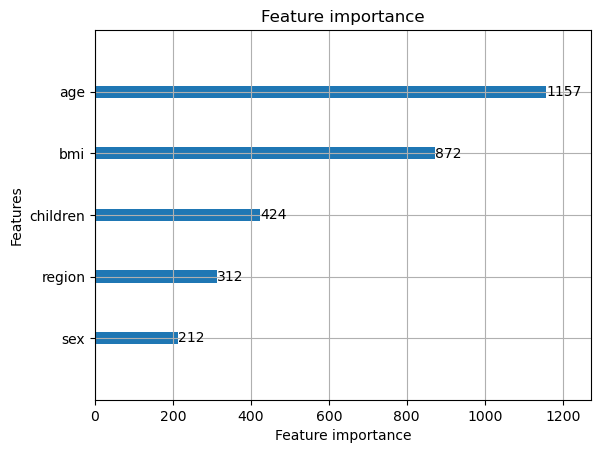

In [1]:
#Modeling
import pandas as pd
df=pd.read_csv("insurance.csv")
def transfer(file_path):
    df=pd.read_csv(file_path)
    sex_mapping = {'female': 0, 'male': 1}
    region_mapping = {'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3}
    smoker_mapping = {'no': 0, 'yes': 1}
    df['smoker'] = df['smoker'].replace(smoker_mapping)
    df['sex'] = df['sex'].replace(sex_mapping)
    df['region'] = df['region'].replace(region_mapping)
    return df
df=transfer("insurance.csv")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import median_absolute_error
smoker= df[df['smoker']==1]
nonsmoker= df[df['smoker']==0]
smoker_X=smoker.drop(['charges'],axis=1)
smoker_y=smoker['charges']
nonsmoker_X=nonsmoker.drop(['charges'],axis=1)

nonsmoker_y=nonsmoker['charges']
X=df.drop(['charges'],axis=1)
y=df['charges']



X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 4118)
import lightgbm
lgb1 = lightgbm.LGBMRegressor(objective = 'mae')
lgb1.fit(smoker_X, smoker_y)
lightgbm.plot_importance(lgb1);
lgb2 = lightgbm.LGBMRegressor(objective = 'mae')
lgb2.fit(nonsmoker_X, nonsmoker_y)
lightgbm.plot_importance(lgb2)

现在我们有这个数据，这个数据的组成是......（就是这个数据是什么，由什么构成）
我们知道，吸烟是会影响身体健康的，因此我们认为，吸烟者和非吸烟者的数据应该分开来看

因此，我们根据吸烟者和非吸烟者，age-bmi作为自变量，对charge为因变量，分别画了两个图片（重要程度是由xgboost得出来的）
# 非吸烟者

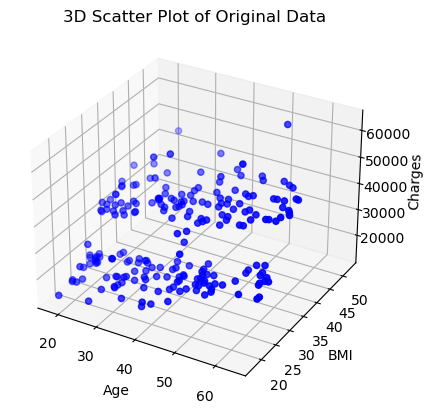

<Figure size 640x480 with 0 Axes>

In [2]:
# 加载数据并筛选吸烟者
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv("train_smoker_dataset.csv")
df=df[['age','bmi', 'charges']]
data = df.values
# scaler=preprocessing.StandardScaler().fit(data)
# data=scaler.transform(data)
df=pd.DataFrame(data,columns=['age','bmi','charges'])
# 选择特征和目标变量
X = df[['age', 'bmi']]
Y = df['charges']


# 绘制原始数据的3D散点图
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X['age'], X['bmi'], Y, color='blue')
ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Charges')
plt.title('3D Scatter Plot of Original Data')
plt.show()
plt.savefig('smoker.jpg')

我们可以看到，两张图片里面，第一张和第二张都有一个看上去比较线性的一个关系，因此我们考虑对两个部分进行分别的线性回归
# 数据预处理
我们将数据随机分为两部分，一部分是训练集，一部分是测试集 0.7/0.3的比例
并且我们先做归一化处理
# 吸烟者

思考单变量线性回归的可能性（这个可以不写）
这里用到了pairplot的一些东西

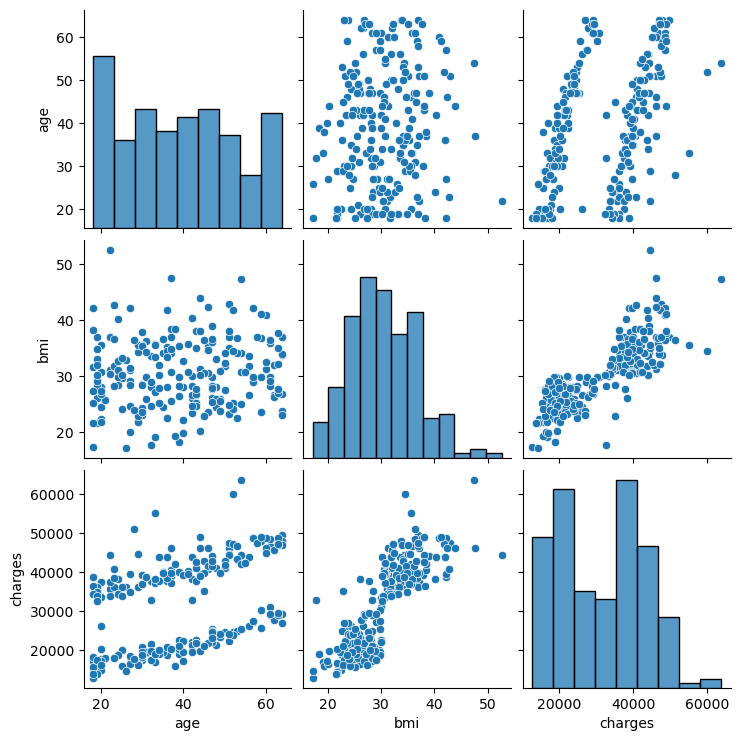

In [3]:

import seaborn as sns

# Calculate the correlation matrix
corr = df.corr()
sns.pairplot(df)

我们可以发现，吸烟者这里的数据可以被明显分为两个部分。(无论是从图像还是从pairplot中看都可以看出来)
简单的想法是，我们可以把数据分成两类，然后对两类数据分别进行线性回归。
具体实现的步骤为：
在训练集中
我们先用GMM进行聚类，对数据分割，打上class 1,2 的标签
且训练一个SVM对数据进行分类
最后对两类数据分别进行线性回归
在测试集中，我们将直接使用SVM对数据进行分类，然后对两类数据分别进行线性回归

In [4]:
# 数据载入

# Assuming the dataset includes a 'smoker' column
# Filter for smokers

# Assuming the dataset includes 'age', 'charges', and 'bmi' columns
# Create a new array with BMI and charges (and optionally age if relevant)
# Here, I am assuming that the structure is similar to the previous dataset

# Fit Gaussian Mixture Model
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(data)

# Predict clusters
predicted_clusters = gmm.predict(data)
df['cluster'] = predicted_clusters
change=False
import os
if not os.path.exists('train_smoker_dataset_labeled.csv') or change:
    df.to_csv('train_smoker_dataset_labeled.csv', index=False)
df=pd.read_csv('train_smoker_dataset_labeled.csv')
predicted_clusters=df['cluster'].values

e:\anaconda3\envs\test\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 0.92, '3D Scatter Plot of Predicted Clusters')

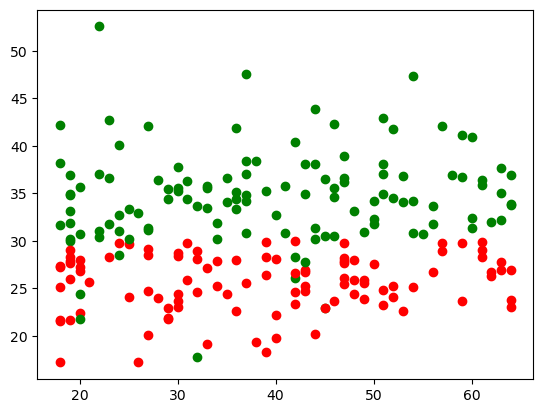

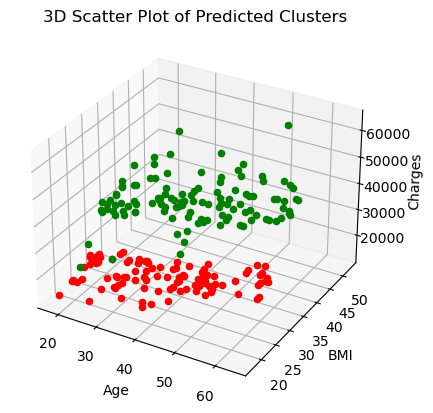

In [5]:
# Visualization
for i, data_point in enumerate(data):
    color = 'green' if predicted_clusters[i] == 1 else 'red'
    plt.scatter(data_point[0], data_point[1], color=color)

# Plot 3d scatter plot with predicted clusters with red and green
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, data_point in enumerate(data):
    color = 'green' if predicted_clusters[i] == 1 else 'red'
    ax.scatter(data_point[0], data_point[1], data_point[2], color=color)
ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Charges')
plt.title('3D Scatter Plot of Predicted Clusters')

In [6]:
import pandas as pd
from sklearn.svm import SVC,SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Load training data
# ... [your existing training data preparation code] ...

# Train the model with grid search on the training data
known_data=df[['age','bmi']].values
clf = SVC(kernel="linear").fit(known_data, predicted_clusters )
# Best model after grid search
best_model = clf

class1
0.7358833028942893
class0
0.9591511439700683


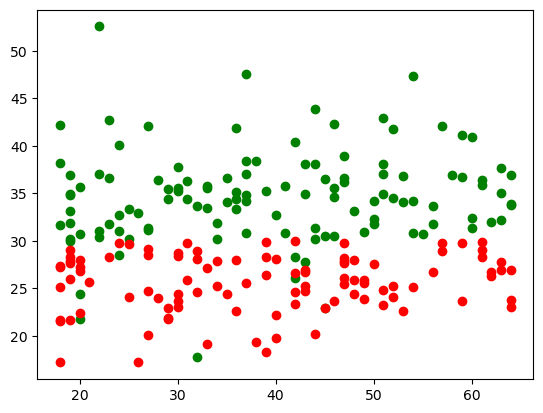

In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np
# Extract 'age' and 'bmi' from the DataFrame
age = df['age'].values
bmi = df['bmi'].values
charges=df['charges'].values

# Separate 'age' and 'bmi' based on 'predicted_clusters'
age_class_1 = age[df['cluster'] == 1]
bmi_class_1 = bmi[df['cluster'] == 1]
charge_class_1=charges[df['cluster'] == 1]
x1= np.column_stack((age_class_1, bmi_class_1))
model1 = LinearRegression()
model1.fit(x1, charge_class_1)
predict1=model1.predict(x1)
from sklearn.metrics import r2_score
print("class1")
print(r2_score(charge_class_1, predict1))#这里ok的
plt.scatter(age_class_1, bmi_class_1, color='green', label='Class 1')


age_class_0 = age[df['cluster'] == 0]
bmi_class_0 = bmi[df['cluster'] == 0]
x0= np.column_stack((age_class_0, bmi_class_0))
charge_class_0=charges[df['cluster'] == 0]
model0 = LinearRegression()
model0.fit(x0, charge_class_0)
predict0=model0.predict(x0)
from sklearn.metrics import r2_score
print("class0")
print(r2_score(charge_class_0, predict0))
# Scatter plot



plt.scatter(age_class_0, bmi_class_0, color='red', label='Class 0')

In [9]:
# 在测试集中泡泡
from sklearn.metrics import r2_score
test=pd.read_csv('test_smoker_dataset.csv')
test_data = test[['age','bmi']].values
# test_data=scaler.transform(test_data)
label=clf.predict(test_data)
import numpy as np

# Assuming label is a NumPy array with the same length as test_data
label0_indices = label == 0
label1_indices = label == 1

# Separate test_data based on labels
label0_data = test_data[label0_indices]
label1_data = test_data[label1_indices]

# Make predictions for each group
predict_test_0 = model0.predict(label0_data)
predict_test_1 = model1.predict(label1_data)

# Initialize an array to hold the combined predictions
combined_predictions = np.zeros_like(label, dtype=float)

# Assign predictions back to the corresponding indices
combined_predictions[label0_indices] = predict_test_0
combined_predictions[label1_indices] = predict_test_1

# combined_predictions now contains the predictions in the original order of test_data


# Calculate and print mean squared error
r2score = r2_score(test['charges'], combined_predictions)
print("R2 Score: {}".format(r2score))

R2 Score: 0.8852827156207785


结果总体还是不错的。在r2 score这一部分确实不错，但是mse这块就不行了
原因来自于具有量纲，因此我们考虑归一化



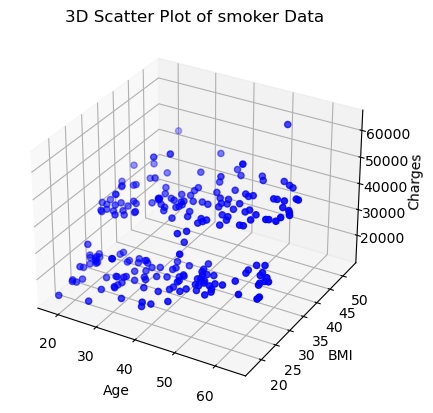

0.7663056806683795


<Figure size 640x480 with 0 Axes>

In [11]:
from sklearn import preprocessing
df = pd.read_csv("train_smoker_dataset.csv")
data = df[['age','bmi', 'charges']].values
# scaler=preprocessing.StandardScaler().fit(data)
# processed=scaler.transform(data)
processed=pd.DataFrame(data,columns=['age','bmi','charges'])
# 选择特征和目标变量
X = processed[['age', 'bmi']]
Y = processed['charges']



# 绘制原始数据的3D散点图
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X['age'], X['bmi'], Y, color='blue')
ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Charges')
plt.title('3D Scatter Plot of smoker Data')
plt.show()
plt.savefig('smoker.jpg')
# write a regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, Y)
predict=model.predict(X)
from sklearn.metrics import r2_score
print(r2_score(Y, predict))


接下来我们来看nonsmoker的这一部分
# nonsmoker

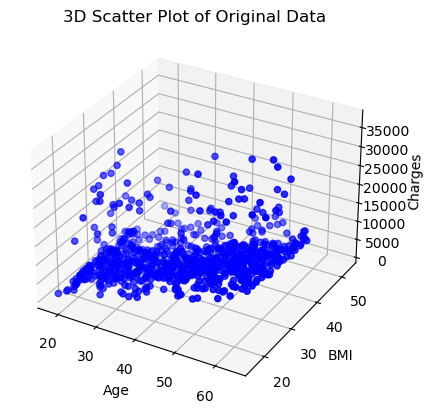

R² score of original model: 0.38313960162899263


In [14]:
# 加载数据并筛选非吸烟者
df = transfer("train_nosmoker_dataset.csv")

# 选择特征和目标变量
X = df[['age', 'bmi']]
Y = df['charges']
# scaler1=preprocessing.StandardScaler().fit(X)
# X=scaler1.transform(X.values)
# scaler2=preprocessing.StandardScaler().fit(Y.values.reshape(-1,1))
# Y=scaler2.transform(Y.values.reshape(-1,1))
# data=np.hstack((X,Y))
# df=pd.DataFrame(data,columns=['age','bmi','charges'])

# 创建并训练线性回归模型
regr = LinearRegression()
regr.fit(X, Y)

# 绘制原始数据的3D散点图
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['age'], df['bmi'], Y, color='blue')
ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Charges')
plt.title('3D Scatter Plot of Original Data')
plt.show()

# 预测并计算残差
predict = regr.predict(X)
residual = predict - Y

# 计算并打印 R² 分数
print("R² score of original model:", r2_score(Y, predict))

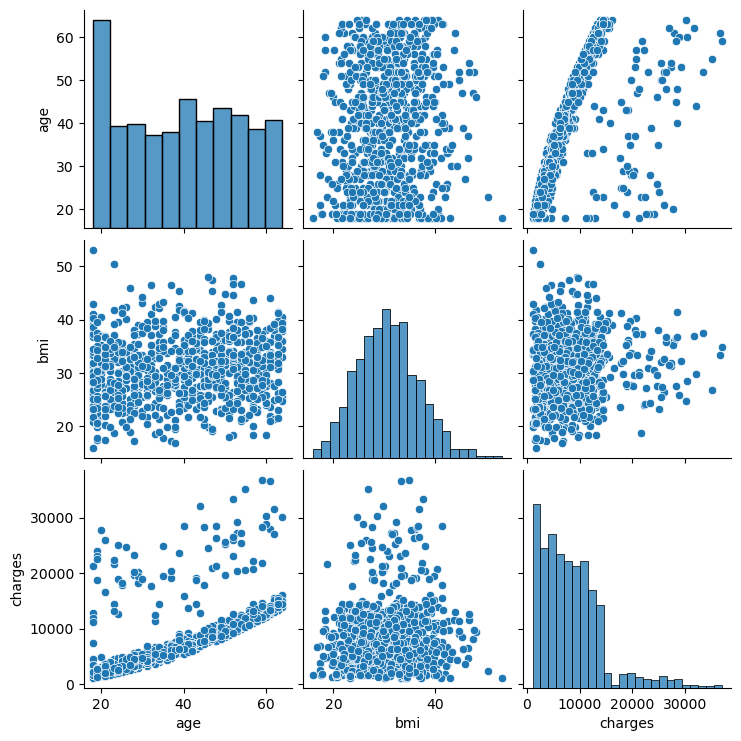

In [17]:

sns.pairplot(df[['age','bmi', 'charges']])

值并不是很好，但是同时我们也可以观察到（通过pairplot)
通过观察可以知道，这里的图片大概是，一个线性再加一些散点
因此我们依然考虑data processing的办法（这一段删掉）

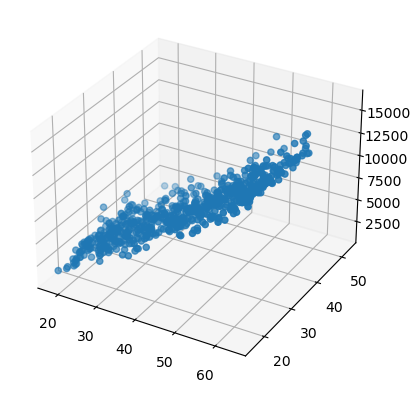

0.9668588017329806


In [13]:

import math
from sklearn.metrics import mean_squared_error as mse
residual=residual/math.sqrt((mse(Y,predict)))

residual=pd.DataFrame(residual)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X=X[(residual['charges']<0.5) & (residual['charges']>-0.5)]
Y=Y[(residual['charges']<0.5) & (residual['charges']>-0.5)]
ax.scatter(X['age'],X['bmi'],Y)
plt.show()
regr.fit(X,Y)
predict=regr.predict(X)
residual=predict-Y
print(r2_score(Y, predict))

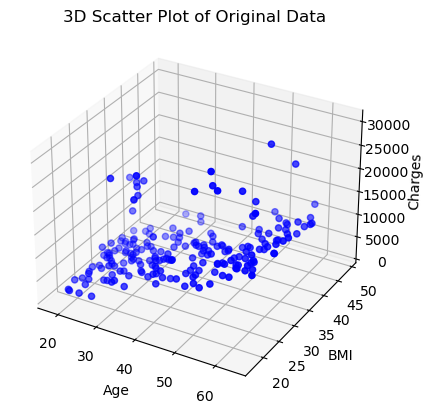

R² score of original model: 0.40062893672132904


In [14]:
# 加载数据并筛选非吸烟者
df = pd.read_csv("test_nosmoker_dataset.csv")
df = df[df['smoker'] == 'no']

# 选择特征和目标变量
X = df[['age', 'bmi']]
Y = df['charges']

# 创建并训练线性回归模型

# 绘制原始数据的3D散点图
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X['age'], X['bmi'], Y, color='blue')
ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Charges')
plt.title('3D Scatter Plot of Original Data')
plt.show()

# 预测并计算残差
predict = regr.predict(X)
residual = predict - Y

# 计算并打印 R² 分数
print("R² score of original model:", r2_score(Y, predict))

在这里效果并不是很好
因此我们用xgboost尝试一下（lightbgm和xgboost都试过，这里xgboost效果会好一点点）

In [15]:
import pandas as pd

df=transfer("train_nosmoker_dataset.csv")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import median_absolute_error

X_train = df.drop("charges", axis=1)
y_train = df["charges"]
import lightgbm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
df2=transfer("test_nosmoker_dataset.csv")
X_test=df2.drop("charges", axis=1)
y_test=df2["charges"]


from xgboost import XGBRegressor
import optuna

def objective_xg(trial):
    """Define the objective function"""

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.3, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        "seed" : trial.suggest_categorical('seed', [42]),
        'objective': trial.suggest_categorical('objective', ['reg:squarederror']),
    }
    model_xgb = XGBRegressor(**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    return mean_squared_error(y_test,y_pred)

study_xgb = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xg, n_trials=200,show_progress_bar=True)
print('Best parameters', study_xgb.best_params)
xgb = XGBRegressor(**study_xgb.best_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('Error: ', r2_score(y_test, y_pred))

e:\anaconda3\envs\test\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[I 2023-12-01 14:42:09,895] A new study created in memory with name: no-name-e85e9217-e856-4ba0-b3f2-07edcb3f3bb4


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\PRAGM\AppData\Local\Temp\ipykernel_29404\1718628244.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
C:\Users\PRAGM\AppData\Local\Temp\ipykernel_29404\1718628244.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\PRAGM\AppData\Local\Temp\ipykernel_29404\1718628244.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 

Best parameters {'booster': 'gbtree', 'max_depth': 1, 'learning_rate': 0.019794548865624925, 'n_estimators': 324, 'min_child_weight': 1, 'gamma': 0.0003165679246255052, 'subsample': 0.31700863355200826, 'reg_alpha': 0.5956161326520848, 'reg_lambda': 0.672893529716299, 'seed': 42, 'objective': 'reg:squarederror'}
Error:  0.46356699836488413


e:\anaconda3\envs\test\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


: 

 0.4608087334526726
 比之前好，但是没好到哪里去